In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import random as rn
import tensorflow.keras.backend as K

In [2]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

In [3]:
fb15k_237 = np.load('./data/fb15k_237.npz', allow_pickle=True)

In [4]:
fb_train = fb15k_237['train']
fb_valid = fb15k_237['valid']
fb_test = fb15k_237['test']

In [5]:
entities = set(np.concatenate((fb_train[:,0], fb_train[:,2]), axis=0))
all_relations = set(fb_train[:,1])

num_entities = len(entities)
num_relations = len(all_relations)

ent2idx = dict(zip(entities, range(num_entities)))
rel2idx = dict(zip(all_relations, range(num_relations)))

idx2ent = {idx:ent for ent,idx in ent2idx.items()}
idx2rel = {idx:rel for rel,idx in rel2idx.items()}

In [6]:
train2idx = []

for head, rel, tail in fb_train:
    
    head_idx = ent2idx[head]
    tail_idx = ent2idx[tail]
    rel_idx = rel2idx[rel]

    train2idx.append([head_idx, rel_idx, tail_idx])
    
train2idx = np.array(train2idx)

In [7]:
EMBEDDING_SIZE = 50
BATCH_SIZE = 256
NUM_EPOCHS = 200
MARGIN = 2
SQRT_SIZE = 6 / np.sqrt(EMBEDDING_SIZE)

In [17]:
def get_embedding_model():
    
    entity_input = tf.keras.layers.Input(shape=(1,), name='entity_input')
    
    entity_embedding = tf.keras.layers.Embedding(
        input_dim=num_entities,
        output_dim=EMBEDDING_SIZE,
        name='entity_embeddings',
        embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-SQRT_SIZE, maxval=SQRT_SIZE, seed=123)
        )(entity_input)
    
    #conv_1 = tf.keras.layers.Conv1D(filters=64,kernel_size=2, strides=1,padding='same', name='conv_1')(entity_embedding)
    
    #flatten = tf.keras.layers.Flatten()(conv_1)
    
    #dense = tf.keras.layers.Dense(64)(flatten)
    
    model = tf.keras.Model(inputs=entity_input, outputs=entity_embedding)
    
    return model
    
def get_relation_model():
    
    relation_input = tf.keras.layers.Input(shape=(1,), name='relation_input')

    relation_embedding = tf.keras.layers.Embedding(
        input_dim=num_relations,
        output_dim=EMBEDDING_SIZE,
        name='relation_embeddings',
        embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-SQRT_SIZE, maxval=SQRT_SIZE, seed=123)
    )(relation_input)
    
    #conv_1 = tf.keras.layers.Conv1D(filters=64,kernel_size=2, 
    #                                strides=1,padding='same', name='conv_1')(relation_embedding)
    
    #flatten = tf.keras.layers.Flatten()(conv_1)
    
    #dense = tf.keras.layers.Dense(64)(flatten)
    
    model = tf.keras.Model(inputs=relation_input, outputs=relation_embedding)
    
    return model   
    

In [9]:
def dissimilarity(tensors):
    
    head, rel, tail = tensors
    
    return K.l2_normalize(head + rel - tail, axis=1)

def margin(tensors):
    
    pos, neg = tensors
    
    return K.relu(pos-neg+K.constant(1))

In [10]:
def siamese_model():
    
    input_shape = (1,)
    
    pos_head_input = tf.keras.layers.Input(shape=input_shape, name='pos_head_input')
    neg_head_input = tf.keras.layers.Input(shape=input_shape, name='neg_head_input')
    pos_tail_input = tf.keras.layers.Input(shape=input_shape, name='pos_tail_input')
    neg_tail_input = tf.keras.layers.Input(shape=input_shape, name='neg_tail_input')
    relation_input = tf.keras.layers.Input(shape=input_shape, name='relation_input')
    
    embedding_model = get_embedding_model()
    relation_model = get_relation_model()
    
    pos_h_e = embedding_model(pos_head_input)
    neg_h_e = embedding_model(neg_head_input)
    pos_t_e = embedding_model(pos_tail_input)
    neg_t_e = embedding_model(neg_tail_input)
    rel_e   = relation_model(relation_input)
    
    lambda_layer = tf.keras.layers.Lambda(dissimilarity, name='dis_sim')
    
    pos = lambda_layer([pos_h_e, rel_e, pos_t_e])
    neg = lambda_layer([neg_h_e, rel_e, neg_t_e])
    
    margin_layer = tf.keras.layers.Lambda(margin, name='margin')
    
    margin_vector = margin_layer([pos, neg])
    
    preds = tf.keras.layers.Dense(1, activation='sigmoid')(margin_vector)
    
    model = tf.keras.Model(
        inputs=[pos_head_input, neg_head_input, pos_tail_input, neg_tail_input, relation_input],
        outputs=preds
        )
    
    return model

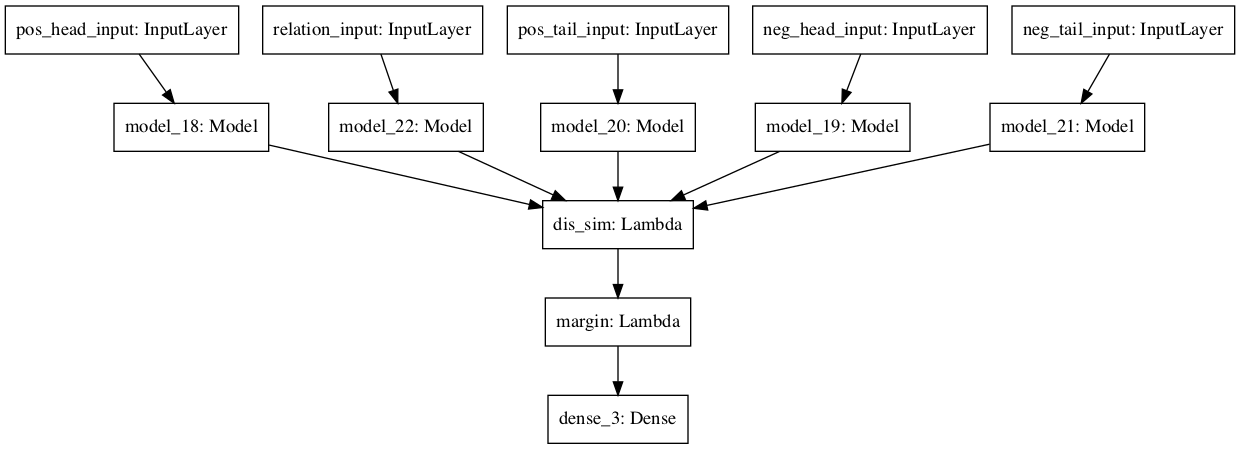

In [16]:
tf.keras.utils.plot_model(siamese_model())
#siamese_model().summary()